Areeba Tanveer <br>
Zainab Kashif

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Embedding, LSTM, Input, add, Reshape, concatenate, Dropout)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [2]:
# Paths to image and captions datasets
image_path = '../input/flickr8k/Images'
captions_path = '../input/flickr8k/captions.txt'

In [3]:
# Set visualization style and suppress warnings
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load captions data
data = pd.read_csv(captions_path)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
# Function to preprocess images: resize, normalize, and convert to array
def readImage(path, img_size=224):
    img = load_img(path, target_size=(img_size, img_size))  # Resize to target size
    img = img_to_array(img)  # Convert to NumPy array
    img = img / 255.0  # Normalize pixel values
    return img

In [6]:
# Function to display images with their captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")  # Read image
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))  # Wrap long captions
        plt.axis("off")
    plt.show()

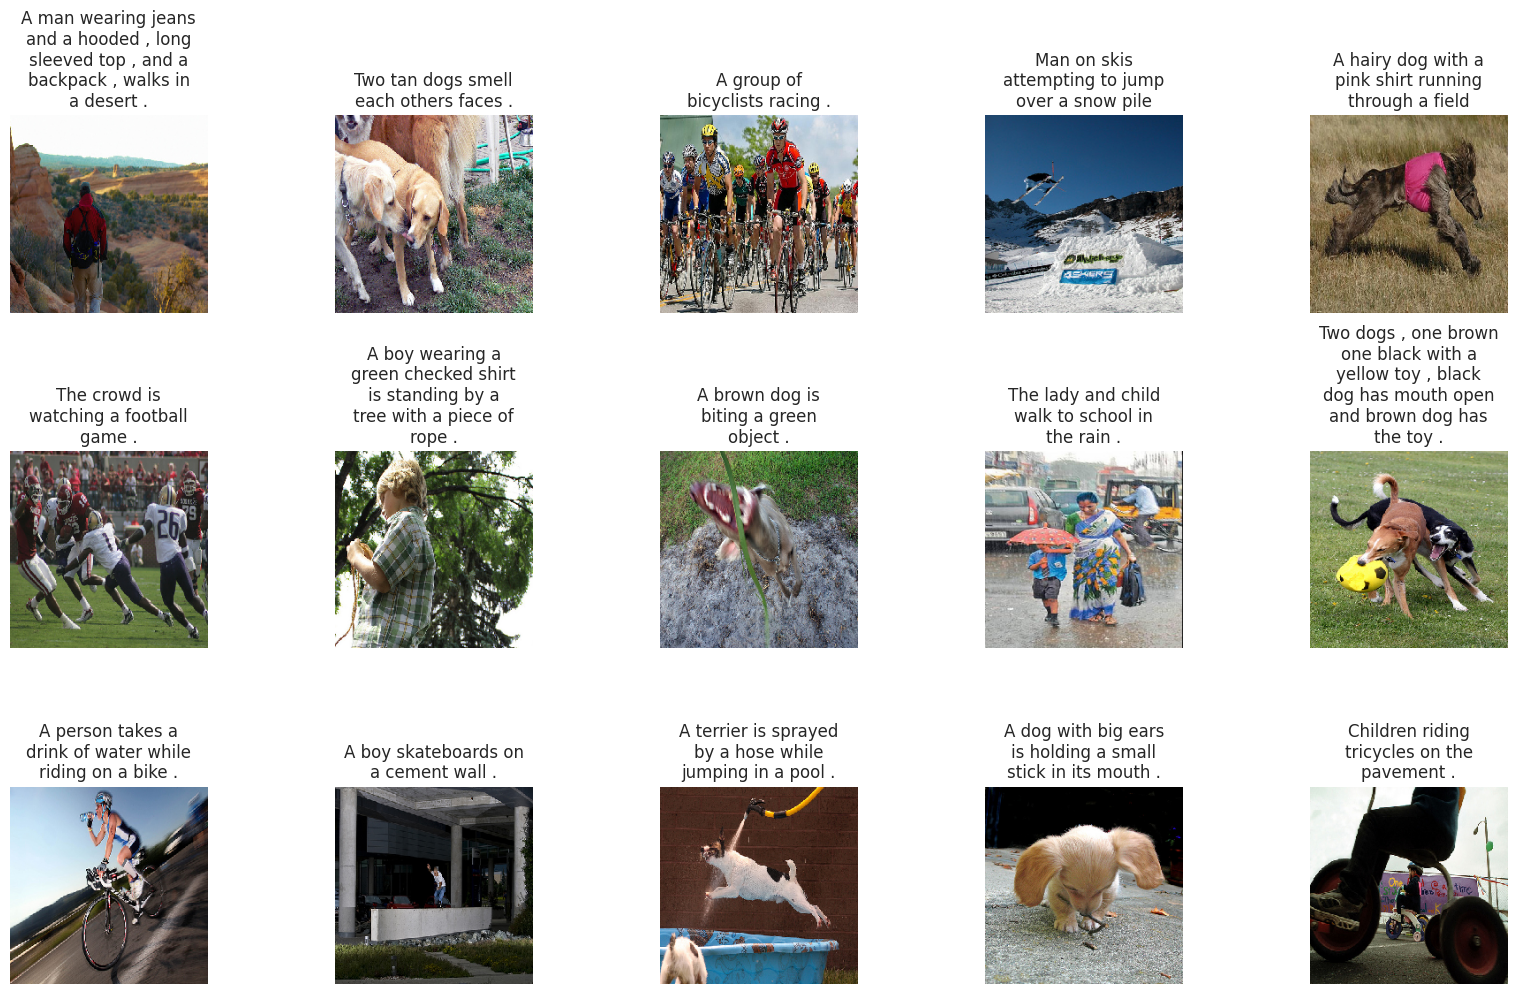

In [7]:
# Display a random sample of 15 images
display_images(data.sample(15))

In [8]:
# Text preprocessing: clean and format captions
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()  # Convert to lowercase
    data['caption'] = data['caption'].str.replace("[^A-Za-z]", "")  # Remove non-alphabetic chars
    data['caption'] = data['caption'].str.replace("\s+", " ")  # Remove extra spaces
    data['caption'] = data['caption'].apply(
        lambda x: " ".join([word for word in x.split() if len(word) > 1])
    )  # Keep words longer than one character
    data['caption'] = "start " + data['caption'] + " end"  # Add start and end tokens
    return data

In [9]:
# Apply text preprocessing to captions
data = text_preprocessing(data)

In [10]:
# Tokenize captions and create a vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])
vocab_size = len(tokenizer.word_index) + 1  # Include padding token
max_length = max(len(caption.split()) for caption in data['caption'])

In [11]:
# Split data into training (75%) and validation (25%) sets
images = data['image'].unique().tolist()
n_images = len(images)
split_index = round(0.75 * n_images)
train_images = images[:split_index]
val_images = images[split_index:]

In [12]:
# Filter dataframes for train and validation datasets
train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

In [13]:
# Extract image features using DenseNet201
model = DenseNet201(weights="imagenet", include_top=False, pooling='avg')  # Pre-trained DenseNet201
features = {}

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Extract features for all unique images
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    feature = model.predict(img, verbose=0)  # Extract features
    features[image] = feature

100%|██████████| 8091/8091 [12:55<00:00, 10.43it/s]


In [30]:
# Custom data generator for feeding data into the model
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        return self.__get_data(batch)

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            img_feature = self.features[row[self.X_col]][0]
            caption = row[self.y_col]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(img_feature)
                X2.append(in_seq)
                y.append(out_seq)
        return (np.array(X1), np.array(X2)), np.array(y)

In [31]:
# Define the image captioning model
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))
img_features = Dense(256, activation='relu')(input1)
sentence_features = Embedding(vocab_size, 256)(input2)
merged = concatenate([Reshape((1, 256))(img_features), sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = add([sentence_features, img_features])
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [32]:
# Callbacks for model training
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)

In [33]:
# Create data generators
train_generator = CustomDataGenerator(train, "image", "caption", 64, tokenizer, vocab_size, max_length, features)
val_generator = CustomDataGenerator(val, "image", "caption", 64, tokenizer, vocab_size, max_length, features)

In [34]:
# Train the model
history = caption_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, earlystopping, lr_reduction])

Epoch 1/10
473/474 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 5.7022
Epoch 1: val_loss improved from inf to 4.34159, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 69s 136ms/step - loss: 5.6995 - val_loss: 4.3416 - learning_rate: 0.0010
Epoch 2/10
473/474 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.1428
Epoch 2: val_loss improved from 4.34159 to 3.94013, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 65s 136ms/step - loss: 4.1425 - val_loss: 3.9401 - learning_rate: 0.0010
Epoch 3/10
473/474 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 3.7395
Epoch 3: val_loss improved from 3.94013 to 3.78867, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 67s 139ms/step - loss: 3.7394 - val_loss: 3.7887 - learning_rate: 0.0010
Epoch 4/10
473/474 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 3.5069
Epoch 4: val_loss improved from 3.78867 to 3.70040, saving model to model.keras
474/474 ━━━━━━━━━━━━━━━━━━━━ 66s 137ms/step - loss: 3.5069 - val_loss: 3.7004 - learning_rate: 0.0010


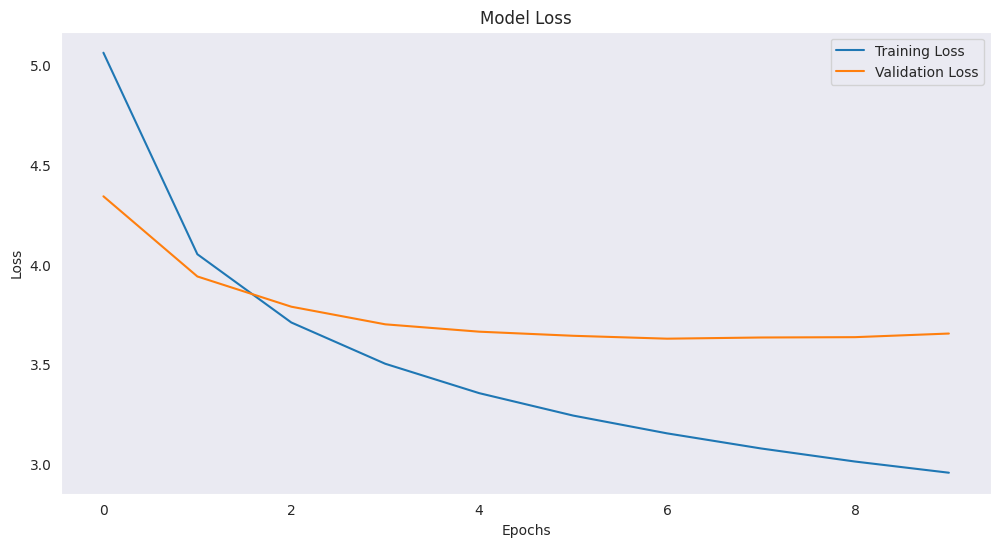

In [35]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Function to map an index to its corresponding word in the tokenizer vocabulary
def idx_to_word(integer, tokenizer):
    # Iterate over all words and their indices in the tokenizer
    for word, index in tokenizer.word_index.items():
        if index == integer:  # Match the given integer with the index
            return word  # Return the word corresponding to the integer
    return None  # Return None if the word is not found

In [50]:
def predict_caption(model, image, tokenizer, max_length, features):
    # Retrieve the precomputed features for the given image
    feature = features[image]
    in_text = "start"  # Initialize the caption with the start token

    # Generate words iteratively up to the maximum sequence length
    for i in range(max_length):
        # Tokenize the current caption text and pad it to the max length
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict the next word using the model
        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)  # Select the word with the highest probability

        # Map the predicted index to the corresponding word
        word = idx_to_word(y_pred, tokenizer)

        if word is None:  # Break if no word is found
            break

        # Append the predicted word to the caption text
        in_text += " " + word

        # Stop if the end token is predicted
        if word == "end":
            break

    return in_text  # Return the generated caption


In [52]:
# Take a random sample of 15 images from the test set
samples = val.sample(15)
samples.reset_index(drop=True, inplace=True)  # Reset indices for the sample

In [53]:
# Loop through each sampled image and predict its caption
for index, record in samples.iterrows():
    # Load and preprocess the image
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Normalize pixel values

    # Predict a caption for the image
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)

    # Update the DataFrame with the predicted caption
    samples.loc[index, 'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

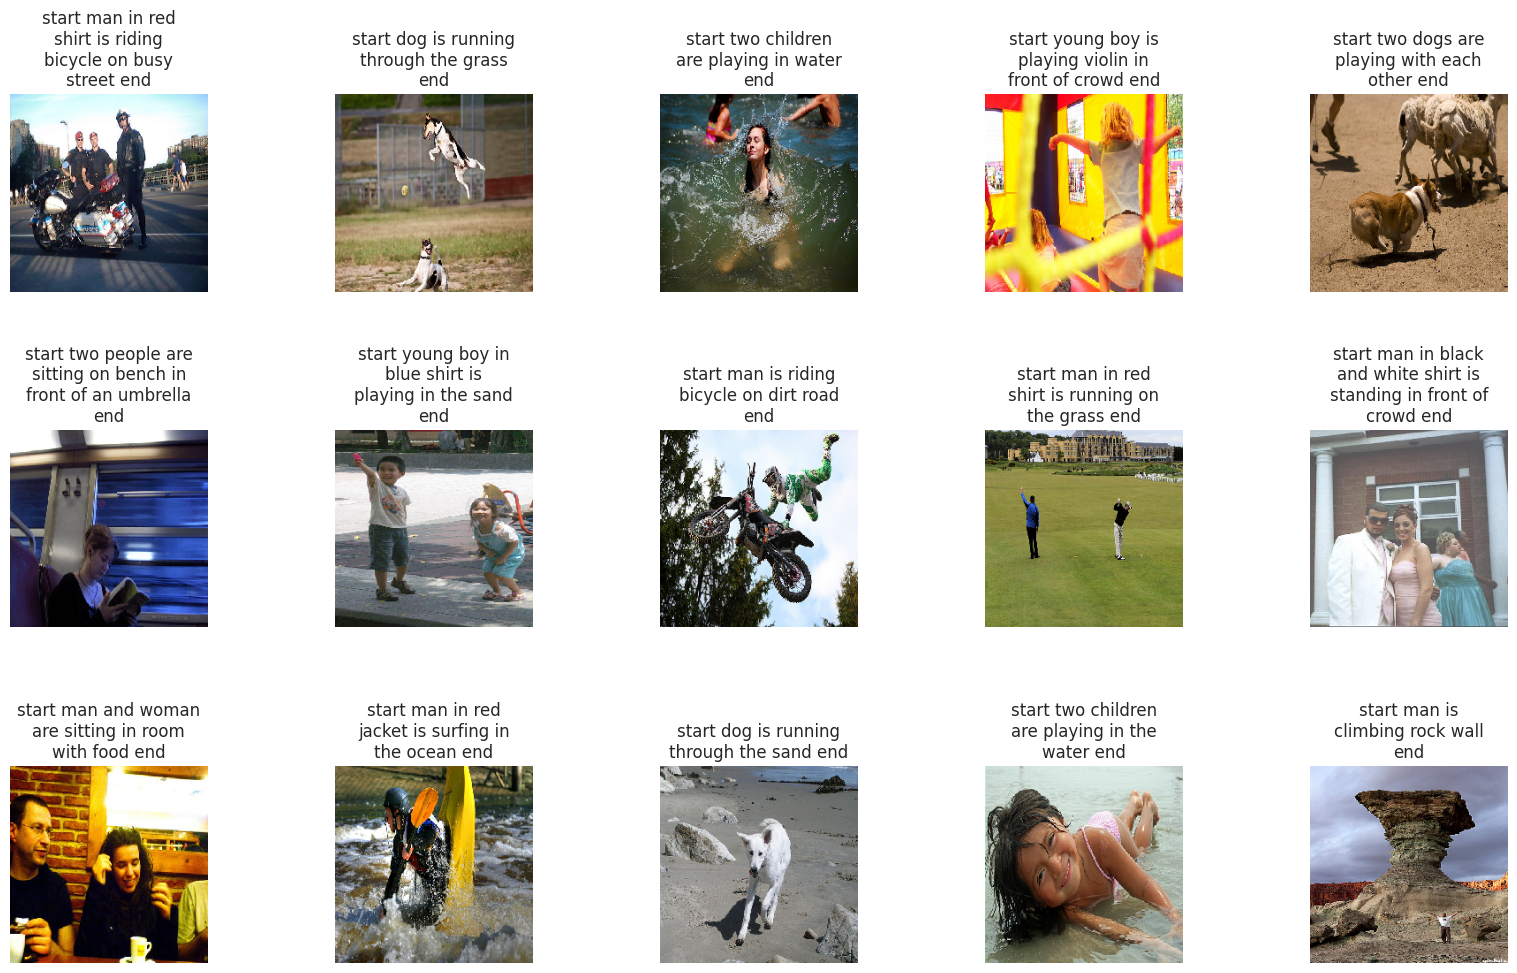

In [54]:
# Display the sampled images with their predicted captions
display_images(samples)

In [68]:
# Save the trained model to a file
from keras.models import load_model

In [69]:
# Save the model to a file with the specified filename
caption_model.save('filename.keras')

In [70]:
# Load the saved model from the file for future use
Loadedmodel = load_model('filename.keras')